# Macro Finance - Project

In [82]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import gmean
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import os
as_of_date = pd.to_datetime('2000-01-01')
annual_factor = 252 # 252 trading days

## Methods

In [83]:
# Function for Annualized Statistics
def summary_statistics_annualized(returns, annual_factor = 12):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""

    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    return summary_statistics

def tangency_weights(returns, cov_mat = 1, annual_factor = 252):
    if cov_mat == 1:
        cov_inv = np.linalg.inv((returns.cov()*annual_factor))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag(cov))
        covmat = cov_mat * cov + (1 - cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat * annual_factor))

    ones = np.ones(returns.columns.shape)
    mu = returns.mean() * annual_factor
    scaling = 1 / (np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(index=returns.columns, data=tangent_return, columns=['Tangent Weights'])
    return tangency_wts

def tangency_weights_long_only_capped(returns, cov_mat=1, annual_factor=252, max_weight=0.35):
    """
    Computes tangency weights that maximize Sharpe ratio with a long-only constraint
    and a per-asset weight cap.
    """
    mu = returns.mean() * annual_factor

    if cov_mat == 1:
        cov = returns.cov() * annual_factor
    else:
        raw_cov = returns.cov()
        diag = np.diag(np.diag(raw_cov))
        cov = cov_mat * raw_cov + (1 - cov_mat) * diag
        cov *= annual_factor

    n = len(mu)
    def neg_sharpe(w):
        port_return = w @ mu
        port_vol = np.sqrt(w @ cov @ w)
        return -port_return / port_vol

    # Constraint: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Bounds: long-only, each weight between 0 and max_weight
    bounds = [(0.0, max_weight) for _ in range(n)]

    # Initial guess: equal weight
    initial_guess = np.ones(n) / n

    # Run optimization
    result = minimize(
        neg_sharpe,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        raise ValueError("Optimization failed:", result.message)

    # Return result as DataFrame
    weights = pd.DataFrame(result.x, index=returns.columns, columns=["Tangency Weights"])
    return weights

# Data Prep

# US 10Y Government Bond (UST)

Components:
- Total Return: <br>
SPBDU1BT Index = S&P U.S. Treasury Bond Current 10-Year Total Return Index <br>
Source: Bloomberg


In [84]:
# 10Y UST Total Return Index
# SPBDU1BT Index = S&P U.S. Treasury Bond Current 10-Year Total Return Index (from BBG)

filepath_rawdata = f'./data/ust_10y_total_return.xlsx'
df_ust_10yr_tot_return = pd.read_excel(filepath_rawdata, sheet_name='Data')
df_ust_10yr_tot_return = df_ust_10yr_tot_return.rename(columns={'TOT_RETURN_INDEX_GROSS_DVDS': 'Total_Return_Index'}).dropna() # Drop Missing Data
df_ust_10yr_tot_return = df_ust_10yr_tot_return.drop(columns={'PX_LAST'})
df_ust_10yr_tot_return = df_ust_10yr_tot_return[df_ust_10yr_tot_return['Date'] >= as_of_date]

# Total Return
total_return_index = df_ust_10yr_tot_return.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'US_Gov'})
df_return = df_return.reset_index()
df_ust_return = df_return.copy()
display(df_ust_return.head())

,Date,US_Gov
0,2000-01-04,0.005253
1,2000-01-05,-0.007742
2,2000-01-06,0.003673
3,2000-01-07,0.003991
4,2000-01-10,-0.003631


# US Equities
Components:
- Total Return: SPX Total Return Index <br>
Source: Bloomberg

In [85]:
# SPX Total Return Index

filepath_rawdata = f'./data/spx_tot_return.xlsx'
spx_tot_return = pd.read_excel(filepath_rawdata, sheet_name = 'Data')
spx_tot_return = spx_tot_return.rename(columns={'TOT_RETURN_INDEX_GROSS_DVDS': 'Total_Return_Index'}).dropna() # Drop Missing Data
spx_tot_return = spx_tot_return.drop(columns={'PX_BID'})

# SPX Total Return
total_return_index = spx_tot_return.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'US_Equities'})
df_return = df_return.reset_index()
df_spx_tot_return = df_return.copy()
display(df_spx_tot_return.head())

,Date,US_Equities
0,2000-01-03,-0.009541
1,2000-01-04,-0.038312
2,2000-01-05,0.002010
3,2000-01-06,0.001155
4,2000-01-07,0.027091


# 10Y European Government Bond
- For measure: Bloomberg Germany 7-10Y Government Bond Total Return Index (BEGRG4 Index)
- The closest maturity available to mimic the 10Y German Bund
- Source: Bloomberg
- Description: https://assets.bwbx.io/documents/users/iqjWHBFdfxIU/rtRmfQxVR8qI/v0

In [86]:
# 10Y German Government Bund Total Return Index (grabbed directly from Bloomberg)

filepath_rawdata = f'./data/bbg_german_7_10.xlsx'
df_bund_10y = pd.read_excel(filepath_rawdata, sheet_name = 'Worksheet')
df_bund_10y = df_bund_10y.rename(columns={'TOT_RETURN_INDEX_GROSS_DVDS': 'Total_Return_Index'}).dropna() # Drop Missing Data
df_bund_10y = df_bund_10y.drop(columns={'PX_LAST'})

# 10Y German Government Bund Total Return
total_return_index = df_bund_10y.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'EUR_Gov'})
df_return = df_return.reset_index()
df_bund_tot_return = df_return.copy()
display(df_bund_tot_return.head())

,Date,EUR_Gov
0,2000-01-03,-0.006785
1,2000-01-04,-0.001165
2,2000-01-05,-0.001458
3,2000-01-06,-0.002160
4,2000-01-07,0.007274


# US High-Yield Credit Market

- To measure: Bloomberg US Corporate High Yield Total Return Index Value Unhedged USD (LF98TRUU Index).
- The Bloomberg US Corporate High Yield Bond Index measures the USD-denominated, high yield, fixed-rate corporate bond market.
- Securities are classified as high yield if the middle rating of Moody's, Fitch and S&P is Ba1/BB+/BB+ or below. 
- Source: Bloomberg
- Description: https://www.bloomberg.com/professional/products/indices/quote/LF98TRUU:IND

In [87]:
# High Yield Corporate Bond Total Return Index (grabbed directly from Bloomberg)

filepath_rawdata = f'./data/bbg_us_hy.xlsx'
df_hy_bond = pd.read_excel(filepath_rawdata, sheet_name = 'Worksheet')
df_hy_bond = df_hy_bond.rename(columns={'TOT_RETURN_INDEX_GROSS_DVDS': 'Total_Return_Index'}).dropna() # Drop Missing Data
df_hy_bond = df_hy_bond.drop(columns={'PX_LAST'})

# High Yield Corporate Bond Total Return
total_return_index = df_hy_bond.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'US_HY'})
df_return = df_return.reset_index()
df_hy_tot_return = df_return.copy()
display(df_hy_tot_return.head())

,Date,US_HY
0,2000-01-03,-0.001839
1,2000-01-04,-0.001149
2,2000-01-05,-0.001516
3,2000-01-06,0.000329
4,2000-01-07,-0.000512


# Global Commodities Market
- To measure: S&P Goldman Sachs Commodity Index (GSCI) --> SPGSCI Index
- Source: Bloomberg

The SPGSCI Index: 
- A benchmark commodities index that tracks the performance of the global commodities market.
- Comprised of 24 exchange-traded futures contracts that cover physical commodities spanning five sectors.
- Tracks energy (oil and natural gas ~54%), grains (wheat, corn, soybeans), livestock, agriculture (coffee, sugar, cocoa), industrial and precious metals. 


In [88]:
# SPGSCI Index: (Used as Total Return Index)

filepath_rawdata = f'./data/sp_gsci.xlsx'
gsci_tot_return = pd.read_excel(filepath_rawdata, sheet_name = 'Worksheet')
gsci_tot_return = gsci_tot_return.rename(columns={'PX_LAST': 'Total_Return_Index'}).dropna()
gsci_tot_return = gsci_tot_return.drop(columns={'CHG_PCT_1D'})

# GSCI Total Return
total_return_index = gsci_tot_return.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'Global_Commodities'})
df_return = df_return.reset_index()
df_gsci_tot_return = df_return.copy()
display(df_gsci_tot_return.head())

,Date,Global_Commodities
0,2000-01-03,-0.001612
1,2000-01-04,-0.009558
2,2000-01-05,-0.009611
3,2000-01-06,-0.000510
4,2000-01-07,-0.009813


In [89]:
# Global Equities (MSCI)

filepath_rawdata = f'./data/Global_Equities.xlsx'
globaleq_tot_return = pd.read_excel(filepath_rawdata, sheet_name = 'Worksheet')
globaleq_tot_return = globaleq_tot_return.rename(columns={'TOT_RETURN_INDEX_GROSS_DVDS': 'Total_Return_Index'}).dropna() # Drop Missing Data

# Total Return
total_return_index = globaleq_tot_return.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'Global_Equities'})
df_return = df_return.reset_index()
df_globeq_tot_return = df_return.copy()
display(df_globeq_tot_return.head())
display(df_globeq_tot_return.tail())

,Date,Global_Equities
0,2010-01-01,0.000000
1,2010-01-04,0.017958
2,2010-01-05,0.002943
3,2010-01-06,0.000735
4,2010-01-07,-0.000487


,Date,Global_Equities
4007,2025-05-13,0.007830
4008,2025-05-14,0.002099
4009,2025-05-15,0.003335
4010,2025-05-16,0.005664
4011,2025-05-17,0.003183


In [90]:
# Global Government Bond (MSCI)
filepath_rawdata = f'./data/Global_Gov.xlsx'
tot_return_index = pd.read_excel(filepath_rawdata, sheet_name = 'Worksheet')
tot_return_index = tot_return_index.rename(columns={'TOT_RETURN_INDEX_GROSS_DVDS': 'Total_Return_Index'}).dropna() # Drop Missing Data

# Total Return
total_return_index = tot_return_index.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'Global_Gov'})
df_return = df_return.reset_index()
df_global_gov = df_return.copy()
display(df_global_gov.head())
display(df_global_gov.tail())

,Date,Global_Gov
0,2010-01-04,0.005028
1,2010-01-05,0.002859
2,2010-01-06,-0.003534
3,2010-01-07,-0.002236
4,2010-01-08,0.001247


,Date,Global_Gov
3993,2025-05-13,0.001120
3994,2025-05-14,0.000521
3995,2025-05-15,0.002460
3996,2025-05-16,0.000492
3997,2025-05-23,0.003200


In [91]:
# Global HY Credit
filepath_rawdata = f'./data/Global_HY.xlsx'
tot_return_index = pd.read_excel(filepath_rawdata, sheet_name = 'Worksheet')
tot_return_index = tot_return_index.rename(columns={'TOT_RETURN_INDEX_GROSS_DVDS': 'Total_Return_Index'}).dropna() # Drop Missing Data

# Total Return
total_return_index = tot_return_index.set_index('Date')
df_return = total_return_index.pct_change().dropna()
df_return = df_return.rename(columns={'Total_Return_Index': 'Global_HY'})
df_return = df_return.reset_index()
df_global_HY = df_return.copy()
display(df_global_HY.head())
display(df_global_HY.tail())

,Date,Global_HY
0,2010-01-04,0.004877
1,2010-01-05,0.004591
2,2010-01-06,0.004615
3,2010-01-07,0.003872
4,2010-01-08,0.001976


,Date,Global_HY
3994,2025-05-14,-0.000062
3995,2025-05-15,-0.001078
3996,2025-05-16,0.000557
3997,2025-05-19,0.001726
3998,2025-05-26,0.000919


# Step 1: MV Optimization for Tangency Portfolio for Global Indexes

In [92]:
# Make a new dataframe for all global indexes
df_total_return = df_globeq_tot_return.copy()

merge1 = pd.merge(df_total_return, df_gsci_tot_return, on='Date', how='inner')
merge2 = pd.merge(merge1, df_global_gov, on='Date', how='inner')
merge3 = pd.merge(merge2, df_global_HY, on='Date', how='inner')

df_return_filtered = merge3.copy()

# Define start and end date
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2023-09-01')

# Filter the DataFrame between start_date and end_date (inclusive)
df_return_filtered = df_return_filtered[
    (df_return_filtered['Date'] >= start_date) &
    (df_return_filtered['Date'] <= end_date)
]
display(df_return_filtered.head())
display(df_return_filtered.tail())

,Date,Global_Equities,Global_Commodities,Global_Gov,Global_HY
1512,2016-01-04,-0.019048,-0.006464,0.000845,-0.003131
1513,2016-01-05,-0.000153,-0.008005,-0.001644,0.001243
1514,2016-01-06,-0.012329,-0.029974,0.003216,-0.000184
1515,2016-01-07,-0.020993,-0.007534,0.002085,-0.002262
1516,2016-01-08,-0.009414,-0.000473,0.003016,0.002083


,Date,Global_Equities,Global_Commodities,Global_Gov,Global_HY
3438,2023-08-28,0.008172,0.000176,0.001774,0.002500
3439,2023-08-29,0.013609,0.002744,0.004731,0.003946
3440,2023-08-30,0.005551,0.000069,0.002933,0.003088
3441,2023-08-31,-0.001588,0.007936,0.000484,-0.001181
3442,2023-09-01,0.001216,0.012783,-0.004160,-0.000912


In [93]:
# Make a new dataframe for all global indexes
df_total_return = df_spx_tot_return.copy()

merge1 = pd.merge(df_total_return, df_ust_return, on='Date', how='inner')
merge2 = pd.merge(merge1, df_hy_tot_return, on='Date', how='inner')

df_return_filtered_US_full = merge2.copy()

# Define start and end date
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2023-09-01')

# Filter the DataFrame between start_date and end_date (inclusive)
df_return_filtered_US = df_return_filtered_US_full[
    (df_return_filtered_US_full['Date'] >= start_date) &
    (df_return_filtered_US_full['Date'] <= end_date)
]
display(df_return_filtered_US.head())
display(df_return_filtered_US.tail())

,Date,US_Equities,US_Gov,US_HY
3987,2016-01-04,-0.015078,0.005568,-0.003319
3988,2016-01-05,0.002012,-0.000873,0.003265
3989,2016-01-06,-0.012761,0.006448,-0.000065
3990,2016-01-07,-0.023674,0.002227,-0.003888
3991,2016-01-08,-0.010835,0.003271,0.001089


,Date,US_Equities,US_Gov,US_HY
5899,2023-08-28,0.006277,0.002950,0.002629
5900,2023-08-29,0.014538,0.007550,0.003753
5901,2023-08-30,0.004001,-0.000232,0.002189
5902,2023-08-31,-0.001367,0.001741,0.000816
5903,2023-09-01,0.001851,-0.007199,0.000120


# MV Optimization Capped
- We are setting a maximum limit of 35% for each asset class. 
- AQR Multi-Asset Fund puts 35% for Fixed-Income class. 
- Source: https://funds.aqr.com/Funds/Multi-Asset/AQR-Multi-Asset-Fund#characteristics

,Mean,Vol,Sharpe
Global_Equities,0.108126,0.160815,0.672367
Global_Commodities,0.112652,0.233103,0.483274
Global_Gov,0.003438,0.052716,0.065211
Global_HY,0.042229,0.058192,0.725684


,Tangency Weights,Sharpe
assets,,
Global_Equities,0.350000,0.672367
Global_Commodities,0.152595,0.483274
Global_Gov,0.147405,0.065211
Global_HY,0.350000,0.725684


,Mean,Vol,Sharpe
Tangency Weights,0.070321,0.092839,0.757452


For the Tangency Portfolio: 
Return: 7.03%
Volatility: 9.28%
Sharpe Ratio: 0.76

For E-Fund Global: 
Return: 3.65%
Volatility: 10.40%
Sharpe Ratio: 0.35


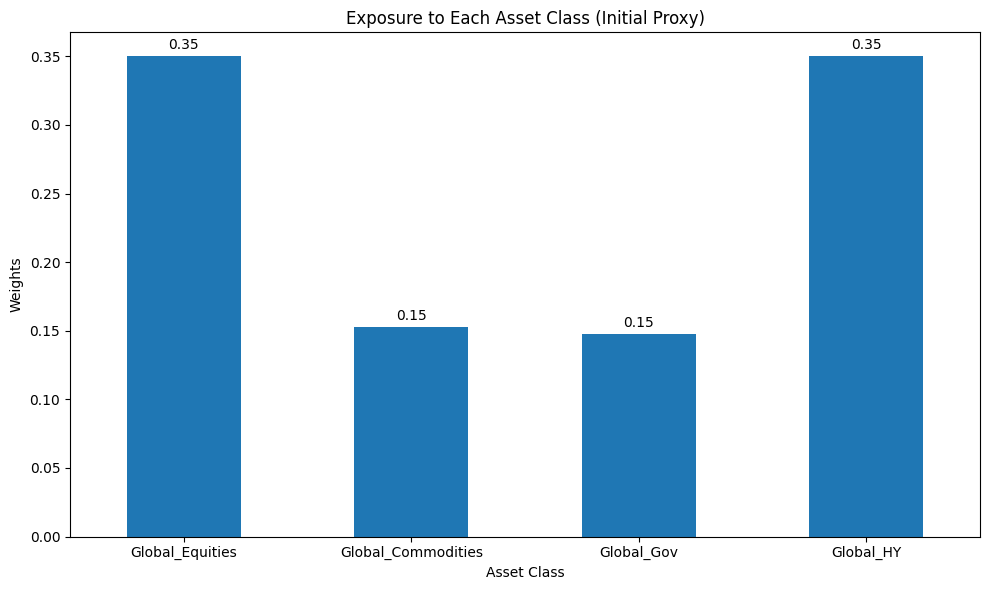

In [94]:
# Input the data for return (must have Date as index):
returns = df_return_filtered.set_index('Date')

summary_stats_individual_asset = summary_statistics_annualized(returns, annual_factor = 252)
display(summary_stats_individual_asset)

# Calculate Tangency Weights
summary_column_sharpe = summary_stats_individual_asset['Sharpe']
# w_t = tangency_weights(returns, cov_mat = 1, annual_factor=252) Non-capped Weights
w_t = tangency_weights_long_only_capped(returns, cov_mat=1, annual_factor=252, max_weight=0.35) # Capped Weights
mv_frontier = w_t.merge(summary_column_sharpe, on=w_t.index).rename(columns={'key_0':'assets'}).set_index('assets')
display(mv_frontier)

# Tangency Portfolio Sharpe Ratio
summary_stats_tangency_port = summary_statistics_annualized(returns @ w_t, annual_factor=252)
summary_stats_tangency_port.rename(index={'Tangent Weights': 'Tangency Portfolio'}, inplace=True)
display(summary_stats_tangency_port)

# Statistics for the Tangency Portfolio
tangency_return = summary_stats_tangency_port['Mean'].mean()
tangency_vol = summary_stats_tangency_port['Vol'].mean()
tangency_sharpe = summary_stats_tangency_port['Sharpe'].mean()

print(f'For the Tangency Portfolio: ')
print(f"Return: {tangency_return:.2%}")
print(f"Volatility: {tangency_vol:.2%}")
print(f"Sharpe Ratio: {tangency_sharpe:.2f}")

efund_return = 3.65/100
efund_vol = 10.4/100
efund_sharpe = efund_return / efund_vol

print(f'\nFor E-Fund Global: ')
print(f"Return: {efund_return:.2%}")
print(f"Volatility: {efund_vol:.2%}")
print(f"Sharpe Ratio: {efund_sharpe:.2f}")

# Create a bar chart
ax = mv_frontier['Tangency Weights'].plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Exposure to Each Asset Class (Initial Proxy)')
plt.xlabel('Asset Class')
plt.ylabel('Weights')
plt.xticks(rotation=0) # Set x-axis labels to be horizontal
# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

# Step 2: Additional Data

In [95]:
# Set path and file names
folder_path = './data/'
file_list = [
    'EMEQ_.xlsx', # Emerging Market Equities
    'EMHY_.xlsx', # Emerging Market HY Credit
    'EMGov_.xlsx', # Emerging Market government bond
]

sheet_name = 'Worksheet'
col_name = 'TOT_RETURN_INDEX_GROSS_DVDS'
start_date = pd.to_datetime('2010-01-01')

# Initialize container for all standardized returns
standardized_df = pd.DataFrame()

# Loop over files
for file in file_list:
    filepath = os.path.join(folder_path, file)

    # Extract asset name from filename
    asset_name = file.split('_')[0].upper()

    # Load and clean data
    df = pd.read_excel(filepath)
    df.columns = ["Date", "Total_Return_Index"]
    df = df[df['Date'] >= start_date].copy()
    df = df.set_index('Date')

    # Compute monthly returns
    df['Return'] = df['Total_Return_Index'].pct_change()
    df = df.dropna()
    # Standardize return
    df[f'{asset_name}'] = df['Return']

    # Add to master DataFrame
    standardized_df = pd.concat([standardized_df, df[[f'{asset_name}']]], axis=1).dropna()

# Reset index to have 'Date' as column
df_canberk = standardized_df.reset_index()
df_canberk = df_canberk.rename(columns={'EMEQ': 'EM_Equities'})
df_canberk = df_canberk.rename(columns={'EMHY': 'EM_HY'})
df_canberk = df_canberk.rename(columns={'EMGOV': 'EM_Gov'})
display(df_canberk.head(3))
display(df_canberk.tail(3))

,Date,EM_Equities,EM_HY,EM_Gov
0,2016-01-05,0.002236,0.002895,0.002650
1,2016-01-06,-0.019120,-0.002221,-0.000094
2,2016-01-07,-0.030864,-0.004005,-0.004720


,Date,EM_Equities,EM_HY,EM_Gov
2355,2025-05-16,-0.000648,0.003670,0.001883
2356,2025-05-19,0.002162,0.001567,0.000663
2357,2025-05-20,-0.001078,-0.003129,-0.001547


In [96]:
# Set path and file names
folder_path = './data/'
file_list = [
    'Chinese Equities (SSE Composite).xlsx',         # Chinese Equities
    'Chinese Government Bond (S&P).xlsx',   # Chinese Government Bond
    'Chinese High Yield Corporate Bond.xlsx',    # Chinese HY Corporate Bonds
    'European Equity Index.xlsx', # European Equities
    'European High Yield Index.xlsx', # European High Yield
    'GSCI Agricultural & Livestock (Commodities).xlsx', # GSCI Agricultural & Livestock
    'GSCI Crude Oil (Commodities).xlsx', # GSCI Crude Oil
    'GSCI Industrials (Commodities Metals).xlsx', # GSCI Industrials
]

sheet_name = 'Worksheet'
col_name = 'TOT_RETURN_INDEX_GROSS_DVDS'
start_date = pd.to_datetime('2016-01-01')

# Initialize container for all standardized returns
standardized_df = pd.DataFrame()

# Loop over files
for file in file_list:
    filepath = os.path.join(folder_path, file)

    # Extract asset name from filename
    asset_name = file.split('_')[0].upper()  # 'spx_totret_1995_monthly.xlsx' → 'SPX'

    # Load and clean data
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    df = df.rename(columns={col_name: 'Total_Return_Index'}).dropna()
    df = df[df['Date'] >= start_date].copy()
    df = df.set_index('Date')

    # Compute monthly returns
    df['Return'] = df['Total_Return_Index'].pct_change()
    df = df.dropna()

    # Standardize return
    df[f'{asset_name}'] = df['Return']

    # Add to master DataFrame
    standardized_df = pd.concat([standardized_df, df[[f'{asset_name}']]], axis=1).dropna()

# Reset index to have 'Date' as column
standardized_df = standardized_df.reset_index()
df_josh = standardized_df
column_names = [
    'Date',
    'China_Equities',
    'China_Gov',
    'China_HY',
    'EUR_Equities',
    'EUR_HY',
    'Agri_Livestock',
    'Oil',
    'Indust_Metals'
]
df_josh.columns = column_names
display(df_josh.head())
display(df_josh.tail())

,Date,China_Equities,China_Gov,China_HY,EUR_Equities,EUR_HY,Agri_Livestock,Oil,Indust_Metals
0,2016-01-04,0.001188,0.002603,0.003050,0.002503,0.006418,-0.002348,0.021965,0.000486
1,2016-01-05,-0.018017,0.005496,0.004630,0.011477,0.000036,0.001736,0.058877,0.002150
2,2016-01-06,0.083492,0.005326,0.006376,0.007688,-0.003789,0.004799,0.021037,0.013446
3,2016-01-07,-0.019332,-0.001433,-0.000389,0.014453,-0.002319,-0.005156,0.003319,0.001070
4,2016-01-08,0.052829,-0.004530,-0.003127,0.002620,0.001040,0.010320,0.055640,0.022260


,Date,China_Equities,China_Gov,China_HY,EUR_Equities,EUR_HY,Agri_Livestock,Oil,Indust_Metals
2177,2025-05-12,-0.001544,0.002501,-0.004077,-0.013098,-0.009581,-0.005295,-0.026781,-0.006900
2178,2025-05-13,-0.008197,0.000423,0.002935,0.000561,-0.001195,0.003707,0.009092,-0.007942
2179,2025-05-14,0.006660,-0.000435,-0.002009,-0.001422,0.001447,0.001387,0.025024,0.008140
2180,2025-05-15,0.004322,0.000790,-0.001634,0.000279,0.002699,0.002184,-0.013235,0.008971
2181,2025-05-16,0.000504,0.000697,0.001450,-0.011020,-0.008336,-0.005196,-0.002734,0.002820


In [97]:
# Merging Data

# Matheus  (US Assets) + EUR_GOV
df_matheus = pd.merge(df_return_filtered_US, df_bund_tot_return, on='Date', how='inner')
display(df_matheus.head())

# Matheus + Canberk
merged_df = pd.merge(df_matheus, df_canberk, on='Date', how='inner')

# Matheus + Canberk + Josh
merged_df_2 = pd.merge(merged_df, df_josh, on='Date', how='inner')
display(merged_df_2.head(3))
display(merged_df_2.tail(3))

,Date,US_Equities,US_Gov,US_HY,EUR_Gov
0,2016-01-04,-0.015078,0.005568,-0.003319,0.004319
1,2016-01-05,0.002012,-0.000873,0.003265,0.002255
2,2016-01-06,-0.012761,0.006448,-0.000065,0.002526
3,2016-01-07,-0.023674,0.002227,-0.003888,-0.002584
4,2016-01-08,-0.010835,0.003271,0.001089,0.001747


,Date,US_Equities,US_Gov,US_HY,EUR_Gov,EM_Equities,EM_HY,EM_Gov,China_Equities,China_Gov,China_HY,EUR_Equities,EUR_HY,Agri_Livestock,Oil,Indust_Metals
0,2016-01-05,0.002012,-0.000873,0.003265,0.002255,0.002236,0.002895,0.002650,-0.018017,0.005496,0.004630,0.011477,0.000036,0.001736,0.058877,0.002150
1,2016-01-06,-0.012761,0.006448,-0.000065,0.002526,-0.019120,-0.002221,-0.000094,0.083492,0.005326,0.006376,0.007688,-0.003789,0.004799,0.021037,0.013446
2,2016-01-07,-0.023674,0.002227,-0.003888,-0.002584,-0.030864,-0.004005,-0.004720,-0.019332,-0.001433,-0.000389,0.014453,-0.002319,-0.005156,0.003319,0.001070


,Date,US_Equities,US_Gov,US_HY,EUR_Gov,EM_Equities,EM_HY,EM_Gov,China_Equities,China_Gov,China_HY,EUR_Equities,EUR_HY,Agri_Livestock,Oil,Indust_Metals
1763,2023-08-30,0.004001,-0.000232,0.002189,-0.001116,-0.003267,-0.002853,-0.002674,0.001622,-0.003709,-0.001896,0.012296,0.007290,0.005288,-0.023915,0.002726
1764,2023-08-31,-0.001367,0.001741,0.000816,0.006203,-0.012355,-0.000859,-0.000932,-0.003240,0.002499,-0.001625,0.008496,0.005316,-0.002267,-0.022445,-0.014359
1765,2023-09-01,0.001851,-0.007199,0.000120,-0.005007,0.011744,0.000144,-0.002472,-0.012773,0.001614,-0.000097,-0.000280,-0.002121,-0.004716,-0.013148,0.008342


,Mean,Vol,Sharpe
US_Equities,0.125928,0.188362,0.668542
US_Gov,0.012427,0.073857,0.168253
US_HY,0.057704,0.055934,1.031633
EUR_Gov,-0.005808,0.056668,-0.102492
EM_Equities,0.085101,0.215311,0.395245
EM_HY,0.030644,0.118445,0.258723
EM_Gov,0.030902,0.107687,0.286965
China_Equities,0.023221,0.191027,0.121557
China_Gov,-0.030644,0.049588,-0.617984
China_HY,-0.035765,0.045034,-0.794179


,Tangency Weights,Sharpe
assets,,
US_Equities,2.033943e-01,0.668542
US_Gov,3.423290e-01,0.168253
US_HY,3.500000e-01,1.031633
EUR_Gov,0.000000e+00,-0.102492
EM_Equities,4.769048e-15,0.395245
EM_HY,7.392473e-16,0.258723
EM_Gov,5.528404e-16,0.286965
China_Equities,9.019533e-02,0.121557
China_Gov,0.000000e+00,-0.617984


,Mean,Vol,Sharpe
Tangency Weights,0.053416,0.055116,0.969161


For the Tangency Portfolio: 
Return: 5.34%
Volatility: 5.51%
Sharpe Ratio: 0.97

For E-Fund Global: 
Return: 3.65%
Volatility: 10.40%
Sharpe Ratio: 0.35


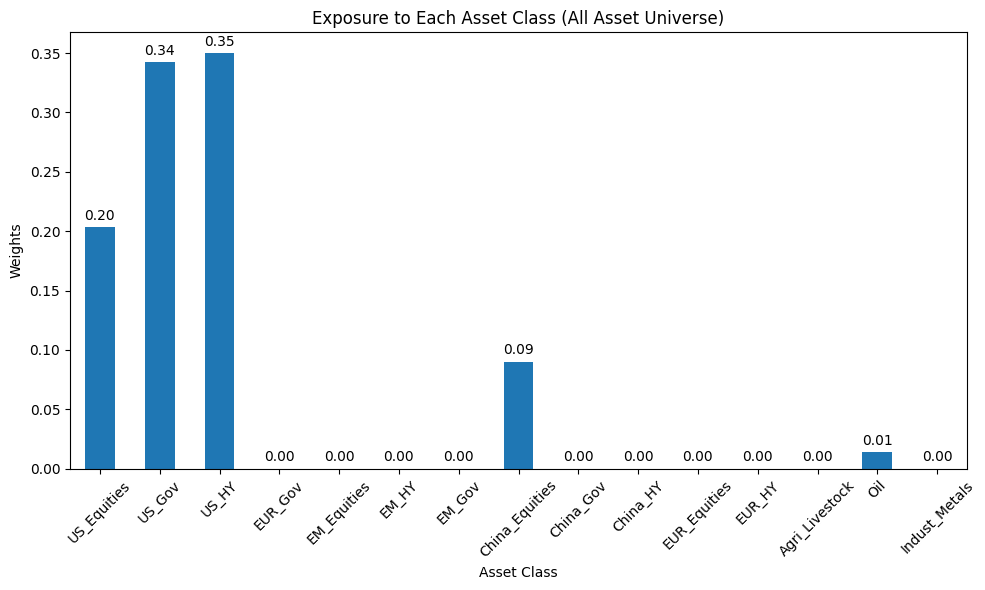

In [98]:
# Input the data for return (must have Date as index):
returns = merged_df_2.set_index('Date')

summary_stats_individual_asset = summary_statistics_annualized(returns, annual_factor = 252)
display(summary_stats_individual_asset)

# Calculate Tangency Weights
summary_column_sharpe = summary_stats_individual_asset['Sharpe']
# w_t = tangency_weights(returns, cov_mat = 1, annual_factor=252) Non-capped Weights
w_t = tangency_weights_long_only_capped(returns, cov_mat=1, annual_factor=252, max_weight=0.35) # Capped Weights
mv_frontier = w_t.merge(summary_column_sharpe, on=w_t.index).rename(columns={'key_0':'assets'}).set_index('assets')
display(mv_frontier)

# Tangency Portfolio Sharpe Ratio
summary_stats_tangency_port = summary_statistics_annualized(returns @ w_t, annual_factor=252)
summary_stats_tangency_port.rename(index={'Tangent Weights': 'Tangency Portfolio'}, inplace=True)
display(summary_stats_tangency_port)

# Statistics for the Tangency Portfolio
tangency_return = summary_stats_tangency_port['Mean'].mean()
tangency_vol = summary_stats_tangency_port['Vol'].mean()
tangency_sharpe = summary_stats_tangency_port['Sharpe'].mean()

print(f'For the Tangency Portfolio: ')
print(f"Return: {tangency_return:.2%}")
print(f"Volatility: {tangency_vol:.2%}")
print(f"Sharpe Ratio: {tangency_sharpe:.2f}")

efund_return = 3.65/100
efund_vol = 10.4/100
efund_sharpe = efund_return / efund_vol

print(f'\nFor E-Fund Global: ')
print(f"Return: {efund_return:.2%}")
print(f"Volatility: {efund_vol:.2%}")
print(f"Sharpe Ratio: {efund_sharpe:.2f}")

# Create a bar chart
ax = mv_frontier['Tangency Weights'].plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Exposure to Each Asset Class (All Asset Universe)')
plt.xlabel('Asset Class')
plt.ylabel('Weights')
plt.xticks(rotation=45) # Set x-axis labels to be horizontal
# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

## MV Optimization: Equities Only

,Mean,Vol,Sharpe
US_Equities,0.125928,0.188362,0.668542
EM_Equities,0.085101,0.215311,0.395245
EUR_Equities,-0.128500,0.214323,-0.599562
China_Equities,0.023221,0.191027,0.121557


,Mean,Vol,Sharpe
Tangency Weights,0.080826,0.134035,0.603025


For the Tangency Portfolio: 
Return: 8.08%
Volatility: 13.40%
Sharpe Ratio: 0.60

For E-Fund Global: 
Return: 3.65%
Volatility: 10.40%
Sharpe Ratio: 0.35


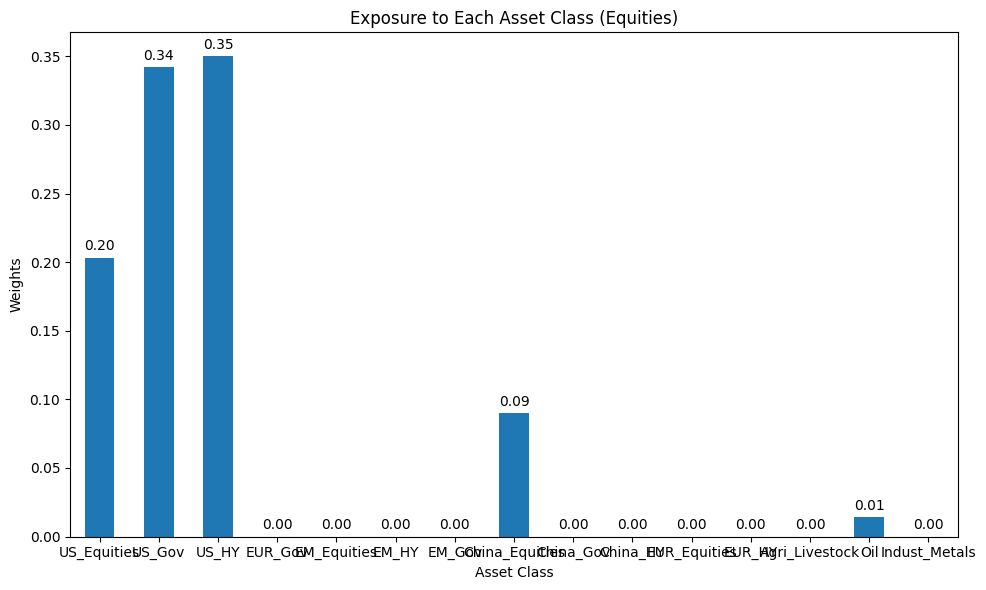

In [99]:
# Equities-Only
df_equities = merged_df_2[['Date', 'US_Equities', 'EM_Equities', 'EUR_Equities', 'China_Equities']]

# Input the data for return (must have Date as index):
returns_equities = df_equities.set_index('Date')

summary_stats_individual_asset = summary_statistics_annualized(returns_equities, annual_factor = 252)
display(summary_stats_individual_asset)

# Calculate Tangency Weights
summary_column_sharpe = summary_stats_individual_asset['Sharpe']
# w_t = tangency_weights(returns, cov_mat = 1, annual_factor=252) # Non-capped Weights
w_t_equities_in_sample = tangency_weights_long_only_capped(returns_equities, cov_mat=0.5, annual_factor=252, max_weight=0.35) # Capped Weights

# Tangency Portfolio Sharpe Ratio
summary_stats_tangency_port = summary_statistics_annualized(returns_equities @ w_t_equities_in_sample, annual_factor=252)
summary_stats_tangency_port.rename(index={'Tangent Weights': 'Tangency Portfolio'}, inplace=True)
display(summary_stats_tangency_port)

# Statistics for the Tangency Portfolio
tangency_return = summary_stats_tangency_port['Mean'].mean()
tangency_vol = summary_stats_tangency_port['Vol'].mean()
tangency_sharpe = summary_stats_tangency_port['Sharpe'].mean()

print(f'For the Tangency Portfolio: ')
print(f"Return: {tangency_return:.2%}")
print(f"Volatility: {tangency_vol:.2%}")
print(f"Sharpe Ratio: {tangency_sharpe:.2f}")

efund_return = 3.65/100
efund_vol = 10.4/100
efund_sharpe = efund_return / efund_vol

print(f'\nFor E-Fund Global: ')
print(f"Return: {efund_return:.2%}")
print(f"Volatility: {efund_vol:.2%}")
print(f"Sharpe Ratio: {efund_sharpe:.2f}")

# Create a bar chart
ax = mv_frontier['Tangency Weights'].plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Exposure to Each Asset Class (Equities)')
plt.xlabel('Asset Class')
plt.ylabel('Weights')
plt.xticks(rotation=0) # Set x-axis labels to be horizontal
# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

## MV Optimization: Government-Bonds Only

,Mean,Vol,Sharpe
US_Gov,0.012427,0.073857,0.168253
EM_Gov,0.030902,0.107687,0.286965
EUR_Gov,-0.005808,0.056668,-0.102492
China_Gov,-0.030644,0.049588,-0.617984


,Mean,Vol,Sharpe
Tangency Weights,0.013423,0.061996,0.21651


For the Tangency Portfolio: 
Return: 1.34%
Volatility: 6.20%
Sharpe Ratio: 0.22

For E-Fund Global: 
Return: 3.65%
Volatility: 10.40%
Sharpe Ratio: 0.35


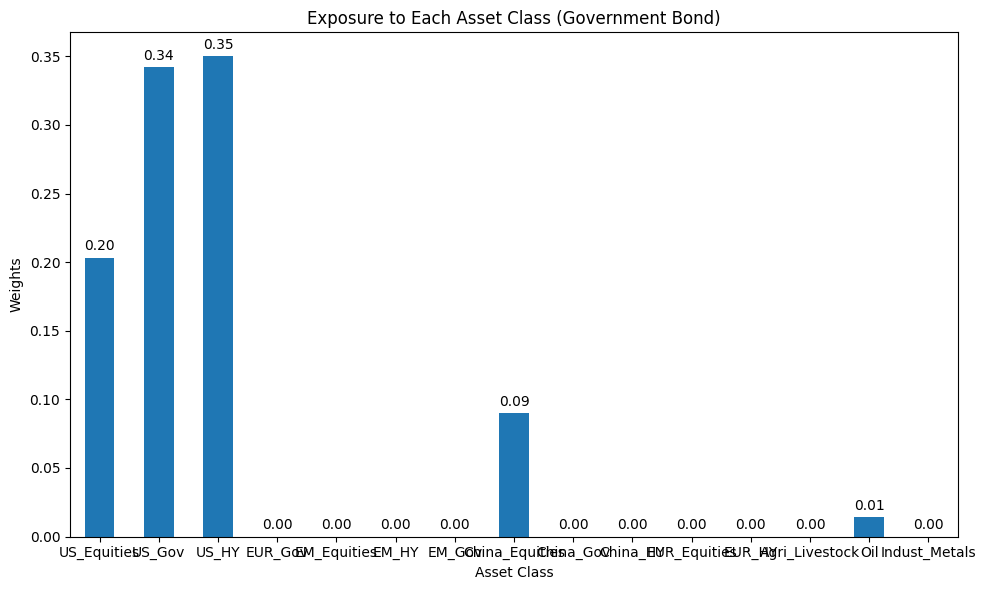

In [100]:
# GovBond-Only
df_govbond = merged_df_2[['Date', 'US_Gov', 'EM_Gov', 'EUR_Gov', 'China_Gov']]

# Input the data for return (must have Date as index):
returns_govbond = df_govbond.set_index('Date')

summary_stats_individual_asset = summary_statistics_annualized(returns_govbond, annual_factor = 252)
display(summary_stats_individual_asset)

# Calculate Tangency Weights
summary_column_sharpe = summary_stats_individual_asset['Sharpe']
# w_t = tangency_weights(returns, cov_mat = 1, annual_factor=252) # Non-capped Weights
w_t_govbond_in_sample = tangency_weights_long_only_capped(returns_govbond, cov_mat=0.5, annual_factor=252, max_weight=0.35) # Capped Weights

# Tangency Portfolio Sharpe Ratio
summary_stats_tangency_port = summary_statistics_annualized(returns_govbond @ w_t_govbond_in_sample, annual_factor=252)
summary_stats_tangency_port.rename(index={'Tangent Weights': 'Tangency Portfolio'}, inplace=True)
display(summary_stats_tangency_port)

# Statistics for the Tangency Portfolio
tangency_return = summary_stats_tangency_port['Mean'].mean()
tangency_vol = summary_stats_tangency_port['Vol'].mean()
tangency_sharpe = summary_stats_tangency_port['Sharpe'].mean()

print(f'For the Tangency Portfolio: ')
print(f"Return: {tangency_return:.2%}")
print(f"Volatility: {tangency_vol:.2%}")
print(f"Sharpe Ratio: {tangency_sharpe:.2f}")

efund_return = 3.65/100
efund_vol = 10.4/100
efund_sharpe = efund_return / efund_vol

print(f'\nFor E-Fund Global: ')
print(f"Return: {efund_return:.2%}")
print(f"Volatility: {efund_vol:.2%}")
print(f"Sharpe Ratio: {efund_sharpe:.2f}")

# Create a bar chart
ax = mv_frontier['Tangency Weights'].plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Exposure to Each Asset Class (Government Bond)')
plt.xlabel('Asset Class')
plt.ylabel('Weights')
plt.xticks(rotation=0) # Set x-axis labels to be horizontal
# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

## MV Optimization: HY Credit Only

,Mean,Vol,Sharpe
US_HY,0.057704,0.055934,1.031633
EM_HY,0.030644,0.118445,0.258723
EUR_HY,-0.043436,0.091613,-0.474124
China_HY,-0.035765,0.045034,-0.794179


,Tangency Weights
US_HY,0.350000
EM_HY,0.350000
EUR_HY,0.019743
China_HY,0.280257


,Mean,Vol,Sharpe
Tangency Weights,0.020041,0.054693,0.366425


For the Tangency Portfolio: 
Return: 2.00%
Volatility: 5.47%
Sharpe Ratio: 0.37

For E-Fund Global: 
Return: 3.65%
Volatility: 10.40%
Sharpe Ratio: 0.35


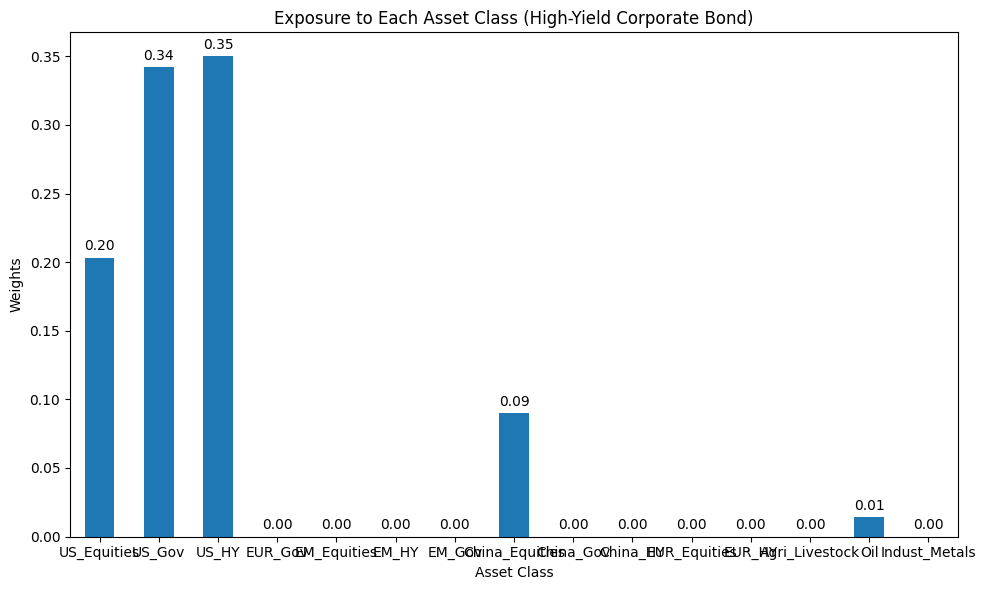

In [101]:
# HY_Credit-Only
df_HYCredit = merged_df_2[['Date', 'US_HY', 'EM_HY', 'EUR_HY', 'China_HY']]

# Input the data for return (must have Date as index):
returns_hy_credit = df_HYCredit.set_index('Date')

summary_stats_individual_asset = summary_statistics_annualized(returns_hy_credit, annual_factor = 252)
display(summary_stats_individual_asset)

# Calculate Tangency Weights
summary_column_sharpe = summary_stats_individual_asset['Sharpe']
# w_t = tangency_weights(returns, cov_mat = 1, annual_factor=252) # Non-capped Weights
w_t_hy_credit_in_sample = tangency_weights_long_only_capped(returns_hy_credit, cov_mat=0.5, annual_factor=252, max_weight=0.35) # Capped Weights
display(w_t_hy_credit_in_sample)

# Tangency Portfolio Sharpe Ratio
summary_stats_tangency_port = summary_statistics_annualized(returns_hy_credit @ w_t_hy_credit_in_sample, annual_factor=252)
summary_stats_tangency_port.rename(index={'Tangent Weights': 'Tangency Portfolio'}, inplace=True)
display(summary_stats_tangency_port)

# Statistics for the Tangency Portfolio
tangency_return = summary_stats_tangency_port['Mean'].mean()
tangency_vol = summary_stats_tangency_port['Vol'].mean()
tangency_sharpe = summary_stats_tangency_port['Sharpe'].mean()

print(f'For the Tangency Portfolio: ')
print(f"Return: {tangency_return:.2%}")
print(f"Volatility: {tangency_vol:.2%}")
print(f"Sharpe Ratio: {tangency_sharpe:.2f}")

efund_return = 3.65/100
efund_vol = 10.4/100
efund_sharpe = efund_return / efund_vol

print(f'\nFor E-Fund Global: ')
print(f"Return: {efund_return:.2%}")
print(f"Volatility: {efund_vol:.2%}")
print(f"Sharpe Ratio: {efund_sharpe:.2f}")

# Create a bar chart
ax = mv_frontier['Tangency Weights'].plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Exposure to Each Asset Class (High-Yield Corporate Bond)')
plt.xlabel('Asset Class')
plt.ylabel('Weights')
plt.xticks(rotation=0) # Set x-axis labels to be horizontal
# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

## MV Optimization: Commodities Only

,Mean,Vol,Sharpe
Oil,0.089351,0.553800,0.161342
Indust_Metals,-0.036403,0.176041,-0.206789
Agri_Livestock,-0.017659,0.145019,-0.121769


,Mean,Vol,Sharpe
Tangency Weights,0.014171,0.233922,0.060582


For the Tangency Portfolio: 
Return: 1.42%
Volatility: 23.39%
Sharpe Ratio: 0.06

For E-Fund Global: 
Return: 3.65%
Volatility: 10.40%
Sharpe Ratio: 0.35


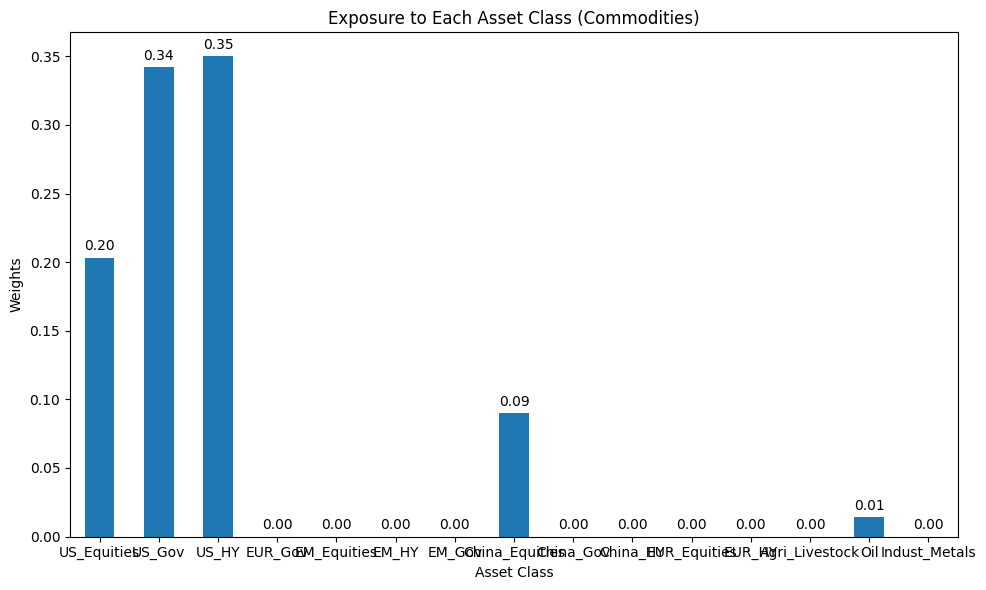

In [102]:
# Commodities-Only
df_commodities = merged_df_2[['Date', 'Oil', 'Indust_Metals', 'Agri_Livestock']]

# Input the data for return (must have Date as index):
returns_commodities = df_commodities.set_index('Date')

summary_stats_individual_asset = summary_statistics_annualized(returns_commodities, annual_factor = 252)
display(summary_stats_individual_asset)

# Calculate Tangency Weights
summary_column_sharpe = summary_stats_individual_asset['Sharpe']
# w_t = tangency_weights(returns, cov_mat = 1, annual_factor=252) # Non-capped Weights
w_t_commodities_in_sample = tangency_weights_long_only_capped(returns_commodities, cov_mat=0.5, annual_factor=252, max_weight=0.35) # Capped Weights

# Tangency Portfolio Sharpe Ratio
summary_stats_tangency_port = summary_statistics_annualized(returns_commodities @ w_t_commodities_in_sample, annual_factor=252)
summary_stats_tangency_port.rename(index={'Tangent Weights': 'Tangency Portfolio'}, inplace=True)
display(summary_stats_tangency_port)

# Statistics for the Tangency Portfolio
tangency_return = summary_stats_tangency_port['Mean'].mean()
tangency_vol = summary_stats_tangency_port['Vol'].mean()
tangency_sharpe = summary_stats_tangency_port['Sharpe'].mean()

print(f'For the Tangency Portfolio: ')
print(f"Return: {tangency_return:.2%}")
print(f"Volatility: {tangency_vol:.2%}")
print(f"Sharpe Ratio: {tangency_sharpe:.2f}")

efund_return = 3.65/100
efund_vol = 10.4/100
efund_sharpe = efund_return / efund_vol

print(f'\nFor E-Fund Global: ')
print(f"Return: {efund_return:.2%}")
print(f"Volatility: {efund_vol:.2%}")
print(f"Sharpe Ratio: {efund_sharpe:.2f}")

# Create a bar chart
ax = mv_frontier['Tangency Weights'].plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Exposure to Each Asset Class (Commodities)')
plt.xlabel('Asset Class')
plt.ylabel('Weights')
plt.xticks(rotation=0) # Set x-axis labels to be horizontal
# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

------------------------------------------

## In-Sample

In [103]:
weighted_equity_returns = returns_equities @ w_t_equities_in_sample
weighted_equity_returns.columns = ['Weighted_Equity_Returns']

weighted_govbond_returns = returns_govbond @ w_t_govbond_in_sample
weighted_govbond_returns.columns = ['Weighted_Govbond_Returns']

weighted_hy_credit_returns = returns_hy_credit @ w_t_hy_credit_in_sample
weighted_hy_credit_returns.columns = ['Weighted_HY_Credit_Returns']

weighted_commodities_returns = returns_commodities @ w_t_commodities_in_sample
weighted_commodities_returns.columns = ['Weighted_Commodities_Returns']


merged_weighted_returns = pd.merge(weighted_equity_returns, weighted_govbond_returns, on='Date', how='inner')
merged_weighted_returns = pd.merge(merged_weighted_returns, weighted_hy_credit_returns, on='Date', how='inner')
merged_weighted_returns = pd.merge(merged_weighted_returns, weighted_commodities_returns, on='Date', how='inner')


weights_asset_class_in_sample = tangency_weights_long_only_capped(merged_weighted_returns, cov_mat=0.5, annual_factor=252, max_weight=0.35)

display(weights_asset_class_in_sample)

summary_stats = summary_statistics_annualized(merged_weighted_returns @ weights_asset_class_in_sample, annual_factor=252)
display(summary_stats)

,Tangency Weights
Weighted_Equity_Returns,0.350000
Weighted_Govbond_Returns,0.276523
Weighted_HY_Credit_Returns,0.350000
Weighted_Commodities_Returns,0.023477


,Mean,Vol,Sharpe
Tangency Weights,0.039348,0.070026,0.561903


-----------------------------------------------------------

## Out-Sample

In [104]:

columns = w_t_equities_in_sample.index.tolist() + w_t_govbond_in_sample.index.tolist() + w_t_hy_credit_in_sample.index.tolist() + w_t_commodities_in_sample.index.tolist()

df_return_filtered_US_full = df_return_filtered_US_full.set_index('Date')
df_josh = df_josh.set_index('Date')
df_bund_tot_return = df_bund_tot_return.set_index('Date')
df_canberk = df_canberk.set_index('Date')

In [105]:
df_all_data = pd.concat([df_return_filtered_US_full, df_josh, df_bund_tot_return, df_canberk], axis=1)
df_all_data = df_all_data.dropna()
start_date = pd.to_datetime('2023-09-02')
df_all_data = df_all_data[df_all_data.index >= start_date]
df_all_data = df_all_data[columns]


equity_weights = w_t_equities_in_sample * weights_asset_class_in_sample.loc["Weighted_Equity_Returns"].values[0]
govbond_weights = w_t_govbond_in_sample * weights_asset_class_in_sample.loc["Weighted_Govbond_Returns"].values[0]
hy_credit_weights = w_t_hy_credit_in_sample * weights_asset_class_in_sample.loc["Weighted_HY_Credit_Returns"].values[0]
commodities_weights = w_t_commodities_in_sample * weights_asset_class_in_sample.loc["Weighted_Commodities_Returns"].values[0]


# merge weights
weights = pd.concat([equity_weights, govbond_weights, hy_credit_weights, commodities_weights], axis=0)

In [106]:
display(weights)
# sum the column
weights_sum = weights['Tangency Weights'].sum()
print(f'Total Weights: {weights_sum:.2f}')

,Tangency Weights
US_Equities,0.122500
EM_Equities,0.122500
EUR_Equities,0.000000
China_Equities,0.105000
US_Gov,0.096783
EM_Gov,0.096783
EUR_Gov,0.082957
China_Gov,0.000000
US_HY,0.122500
EM_HY,0.122500


Total Weights: 1.00


In [107]:
OOS_returns = df_all_data @ weights

OOS_returns_stats = summary_statistics_annualized(OOS_returns, annual_factor=252)

display(OOS_returns_stats)

# I want cumulative returns plotted
cumulative_returns = (1 + OOS_returns).cumprod() - 1
cumulative_returns.columns = ['Cumulative Returns']
cumulative_returns = cumulative_returns.reset_index()
cumulative_returns['Date'] = pd.to_datetime(cumulative_returns['Date'])
cumulative_returns = cumulative_returns.set_index('Date')


,Mean,Vol,Sharpe
Tangency Weights,0.071463,0.059253,1.206071


,Daily Returns
Date,
2023-09-08,0.0000
2023-09-15,0.0050
2023-09-22,0.0007


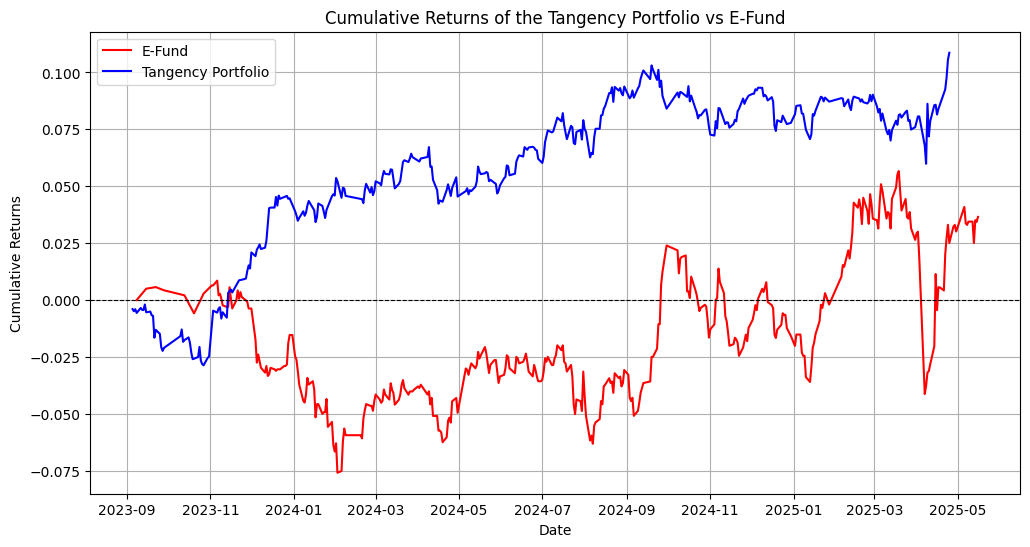

In [108]:
import pandas as pd

efund_df = pd.read_excel('./data/QDII Fund Daily Returns.xlsx')
efund_df = efund_df.sort_values("Date")
efund_df['Date'] = pd.to_datetime(efund_df['Date'])
efund_df = efund_df.set_index("Date")
efund_df = efund_df[['Daily Returns']]

display(efund_df.head(3))

# plot cumulative returns
cumulative_returns_efund = (1 + efund_df).cumprod() - 1
cumulative_returns_efund.columns = ['Cumulative Returns E-Fund']
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_efund.index, cumulative_returns_efund['Cumulative Returns E-Fund'], label='E-Fund', color='red')
plt.plot(cumulative_returns.index, cumulative_returns['Cumulative Returns'], label='Tangency Portfolio', color='blue')
plt.title('Cumulative Returns of the Tangency Portfolio vs E-Fund')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid()
plt.show()